# Support Vector Machine (SVM) from Scratch Using Hinge Loss and Subgradient

This notebook demonstrates the implementation of a linear Support Vector Machine (SVM) classifier **from scratch**, without using scikit-learn’s built-in SVM. The model is trained using **hinge loss** and both **gradient descent (GD)** and **subgradient descent** optimization techniques.

---

## 🔍 Hinge Loss

The hinge loss is commonly used for training "maximum-margin" classifiers, particularly SVMs. It is defined as:

![Hinge Loss](https://miro.medium.com/v2/resize:fit:1400/1*VGoVGKCAQav7nR23sizSjw.png)

## 🎯 SVM Objective Function

SVM aims to minimize the regularized hinge loss:


## 📊 Visualization

![Hinge Loss and Regularization](https://i.sstatic.net/hoaGW.png)

Here is a visualization of the hinge loss function and the effect of the regularization term in the SVM objective.


### Imports essential libraries for data handling, visualization, evaluation, and splitting. `SVC` is imported for comparison at the end.


In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
sns.set_theme()
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

## Imports essential libraries for data handling, visualization, evaluation, and splitting. `SVC` is imported for comparison at the end.


In [6]:
def wrangle(path):
    data=pd.read_csv(path)
    data.isnull().sum()
    data.dropna(inplace=True)
    data.duplicated().sum()
    data.drop(columns='rad',inplace=True)
    data.rename(columns={'chas': 'target'}, inplace=True)
    data['target'] = data['target'].replace(0, -1)
    return data

## Loads the dataset using the `wrangle` function and displays the cleaned DataFrame.


In [7]:
data=wrangle(r"BostonHousing.csv")
data

,crim,zn,indus,target,nox,rm,age,dis,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,-1,0.538,6.575,65.2,4.0900,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,-1,0.469,6.421,78.9,4.9671,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,-1,0.469,7.185,61.1,4.9671,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,-1,0.458,6.998,45.8,6.0622,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,-1,0.458,7.147,54.2,6.0622,222,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,-1,0.573,6.593,69.1,2.4786,273,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,-1,0.573,6.120,76.7,2.2875,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,-1,0.573,6.976,91.0,2.1675,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,-1,0.573,6.794,89.3,2.3889,273,21.0,393.45,6.48,22.0


## Generates a correlation matrix heatmap to visualize feature relationships and help identify potentially redundant or correlated features.


<Axes: >

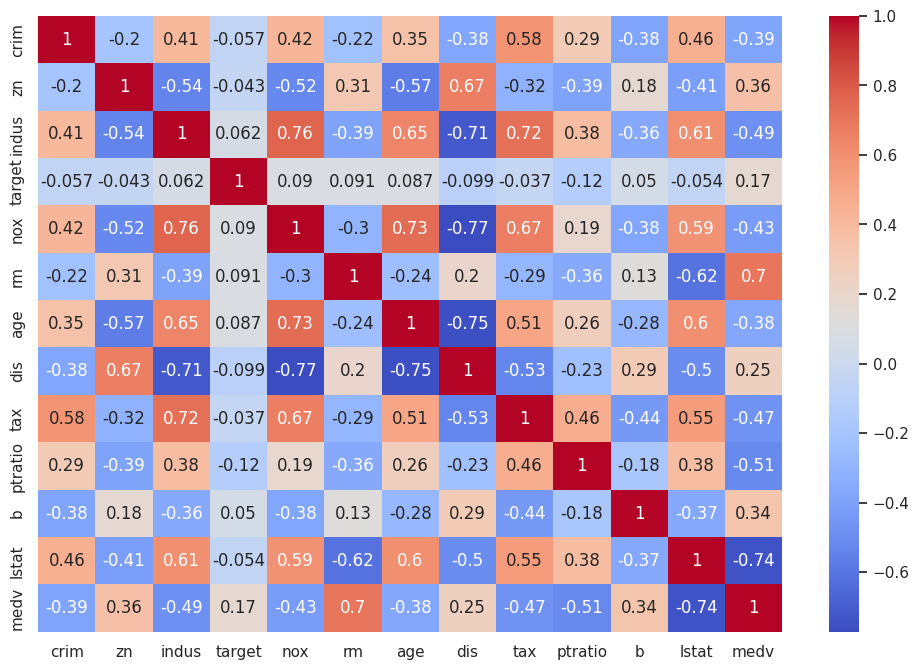

In [8]:
plt.figure(figsize=(12,8))
sns.heatmap(data.corr(),annot=True,cmap='coolwarm')

### Displays the class distribution in the target variable to understand class balance.


<Axes: xlabel='target'>

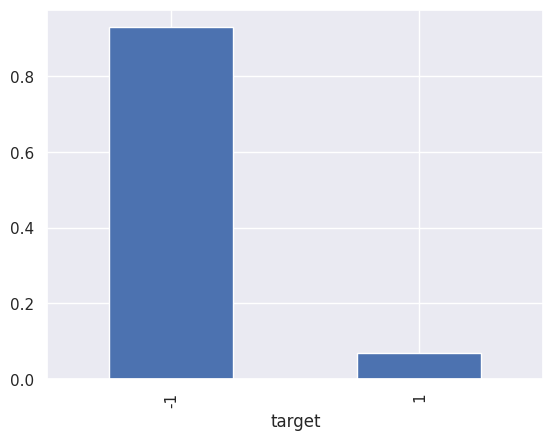

In [9]:
data['target'].value_counts(normalize=True).plot(kind='bar')

### Plots a scatter plot between `age` and `crim` to visually inspect any potential pattern or correlation.


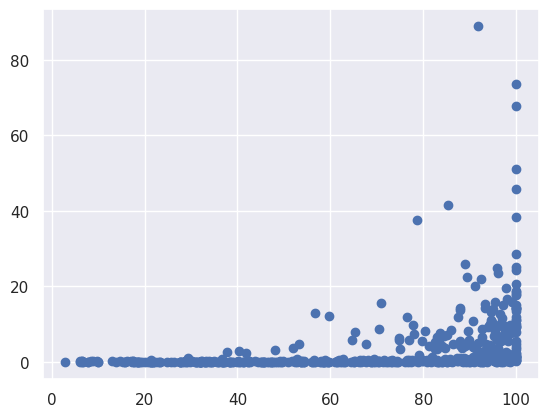

In [10]:
plt.scatter(data['age'],data['crim'])

### Separates features (X) and target (y), converts them to NumPy arrays, and performs an 80-20 train-test split. Further splits training data into training and validation sets.


In [11]:
X=data.drop(columns='target')
y=data['target']
X=X.to_numpy()
y=y.to_numpy()
x_train_val,x_test,y_train_val,y_test=train_test_split(X,y,test_size=0.2)
x_train,x_val,y_train,y_val=train_test_split(x_train_val,y_train_val,test_size=0.2)

## Defines a custom SVM class from scratch with the following methods:
- `__init__`: Sets hyperparameters (learning rate, lambda, epochs, method).
- `loss_calc`: Calculates hinge loss with L2 regularization.
- `accuracy`: Calculates classification accuracy.
- `fit`: Trains the SVM using either gradient descent (`gd`) or subgradient (`subgd`).
- `predict`: Predicts using the learned weights and bias.


In [12]:
class svm_scratch:
    def __init__(self,lr=0.01,lambda_param=0.01,epochs=100,method='gd'):
        self.lr=lr
        self.method=method
        self.lambda_param=lambda_param
        self.epochs=epochs
        self.w=None
        self.b=None
        self.loss_history=[]
        self.acc_train=[]
        self.val_train=[]

    def loss_calc(self,X,y):
        margin=y*(np.dot(X,self.w)+self.b)
        loss=0.5*np.dot(self.w,self.w)+np.mean(np.maximum(0,1-margin))
        return loss

    def accuracy(self,X,y):
        predict=np.sign(np.dot(X,self.w)+self.b)
        return accuracy_score(y_true=y,y_pred=predict)

    def fit(self,X_train,y_train,X_val=None,y_val=None):
        n_sample,n_feature=X_train.shape
        self.w=np.zeros(n_feature)
        self.b=0

        for i in range(0,self.epochs):
            for idx,x_i in enumerate(X_train):
                condition=y_train[idx]*(np.dot(x_i ,self.w)+ self.b)

                if self.method =='gd':
                    if condition >=1 :
                        dw= 2*self.lambda_param*self.w
                        db=0
                    elif condition < 1:
                        dw=2*self.lambda_param*self.w-np.dot(x_i,y_train[idx])
                        db=-y_train[idx]
                elif self.method=='subgd':
                    if condition >1 :
                        dw= 2*self.lambda_param*self.w
                        db=0
                    elif condition < 1:
                        dw=2*self.lambda_param*self.w-np.dot(x_i,y_train[idx])
                        db=-y_train[idx]
                    elif condition==1:
                        rand_int=np.random.uniform(0,1)
                        dw=2*self.lambda_param *self.w + rand_int*(-y_train[idx] * x_i)
                        db=rand_int *-y_train[idx]
                self.w=self.w-self.lr*dw
                self.b=self.b-self.lr*db
            print(f'loss at epoch {i} = {self.loss_calc(X_train,y_train)}')

            self.loss_history.append(self.loss_calc(X_train,y_train))

            self.acc_train.append(self.accuracy(X_train, y_train))
            if X_val is not None and y_val is not None:
                self.val_train.append(self.accuracy(X_val, y_val))

    def predict(self,X):
        output=np.dot(X,self.w)+self.b
        return np.sign(output)






## Initializes and trains two SVM models:
- One using **subgradient descent**
- Another using **gradient descent** (with validation monitoring).


In [13]:
svm_subgrad = svm_scratch(lr=0.001, lambda_param=0.01, epochs=100, method="subgd")
svm_subgrad.fit(x_train, y_train)

svm_grad = svm_scratch(lr=0.001, lambda_param=0.01,epochs=100, method="gd")
svm_grad.fit(x_train, y_train,x_val,y_val)


loss at epoch 0 = 27.256915753737882
loss at epoch 1 = 23.112916639626143
loss at epoch 2 = 16.00292610716297
loss at epoch 3 = 14.739522392692805
loss at epoch 4 = 23.505143132624536
loss at epoch 5 = 22.800162264828938
loss at epoch 6 = 26.766030101463933
loss at epoch 7 = 25.66488301919188
loss at epoch 8 = 27.738123958424605
loss at epoch 9 = 26.64322641767932
loss at epoch 10 = 27.83496832546606
loss at epoch 11 = 26.77556381729994
loss at epoch 12 = 27.99029950001002
loss at epoch 13 = 27.96288849235991
loss at epoch 14 = 26.930331530878654
loss at epoch 15 = 29.26159569923629
loss at epoch 16 = 27.758587018848424
loss at epoch 17 = 27.052053564066554
loss at epoch 18 = 27.975915777443685
loss at epoch 19 = 28.9001817144114
loss at epoch 20 = 28.460513120001565
loss at epoch 21 = 28.64342256584927
loss at epoch 22 = 28.996777408676678
loss at epoch 23 = 26.806751428843423
loss at epoch 24 = 22.56147110647156
loss at epoch 25 = 24.149753313123966
loss at epoch 26 = 32.218603417438

## Similar to the previous cell but evaluates the gradient descent-based SVM model. Shows final accuracies and plots the loss curve.


the Training Accuracy: 92.5
the Validation Accuracy = 96.25
the Test Accuracy = 92.07920792079209


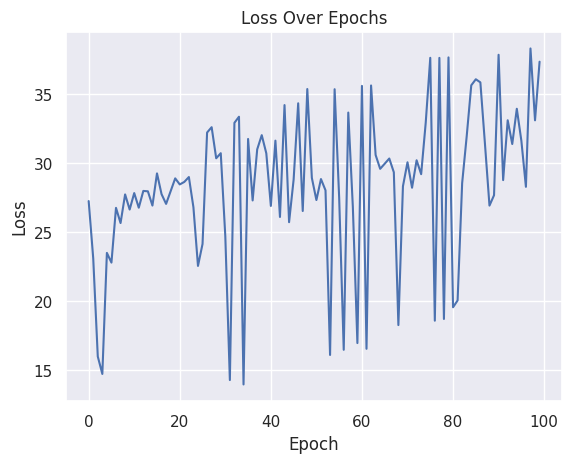

In [14]:
# Loss per epoch
losses_sub = svm_subgrad.loss_history

# Training accuracy per epoch
train_accuracies_sub = svm_subgrad.acc_train

# Validation accuracy per epoch
val_accuracies_sub = svm_subgrad.val_train




print("the Training Accuracy:", train_accuracies_sub[-1]*100)
y_pred_sub=svm_subgrad.predict(x_val)
print(f'the Validation Accuracy = {accuracy_score(y_val,y_pred_sub)*100}')
y_pred_sub=svm_subgrad.predict(x_test)
print(f'the Test Accuracy = {accuracy_score(y_test,y_pred_sub)*100}')



plt.plot(losses_sub)
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()




the Training Accuracy: 92.5
the Validation Accuracy = 96.25
the Test Accuracy = 92.07920792079209


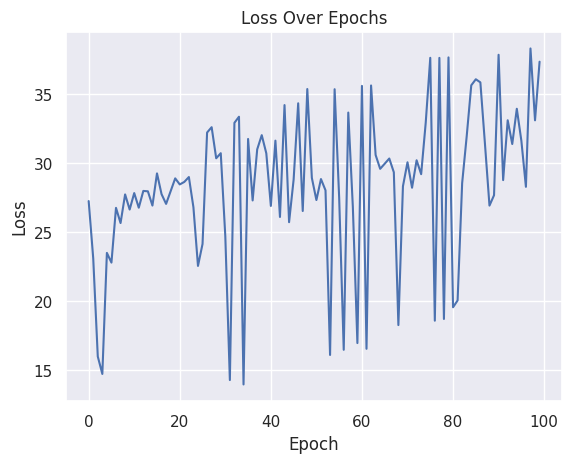

In [15]:
# Loss per epoch
losses_grad = svm_grad.loss_history
# Training accuracy per epoch
train_accuracies_grad = svm_grad.acc_train
# Validation accuracy per epoch
val_accuracies_grad = svm_grad.val_train
print("the Training Accuracy:", train_accuracies_grad[-1]*100)
y_pred_grad=svm_grad.predict(x_val)
print(f'the Validation Accuracy = {accuracy_score(y_val,y_pred_grad)*100}')
y_pred_grad=svm_grad.predict(x_test)
print(f'the Test Accuracy = {accuracy_score(y_test,y_pred_grad)*100}')
plt.plot(losses_grad)
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## Fits a standard SVM model from scikit-learn using a linear kernel and compares its test accuracy with the custom implementation.


In [16]:
svc_model = SVC(kernel='linear', C=1.0)
svc_model.fit(x_train, y_train)
y_pred_sklearn = svc_model.predict(x_test)
print(f'the Test Accuracy = {accuracy_score(y_test, y_pred_sklearn)*100}')


the Test Accuracy = 92.07920792079209


## Displays a confusion matrix heatmap for the gradient descent-based model on the test set to visualize classification performance.


# **For confusion_matrix**

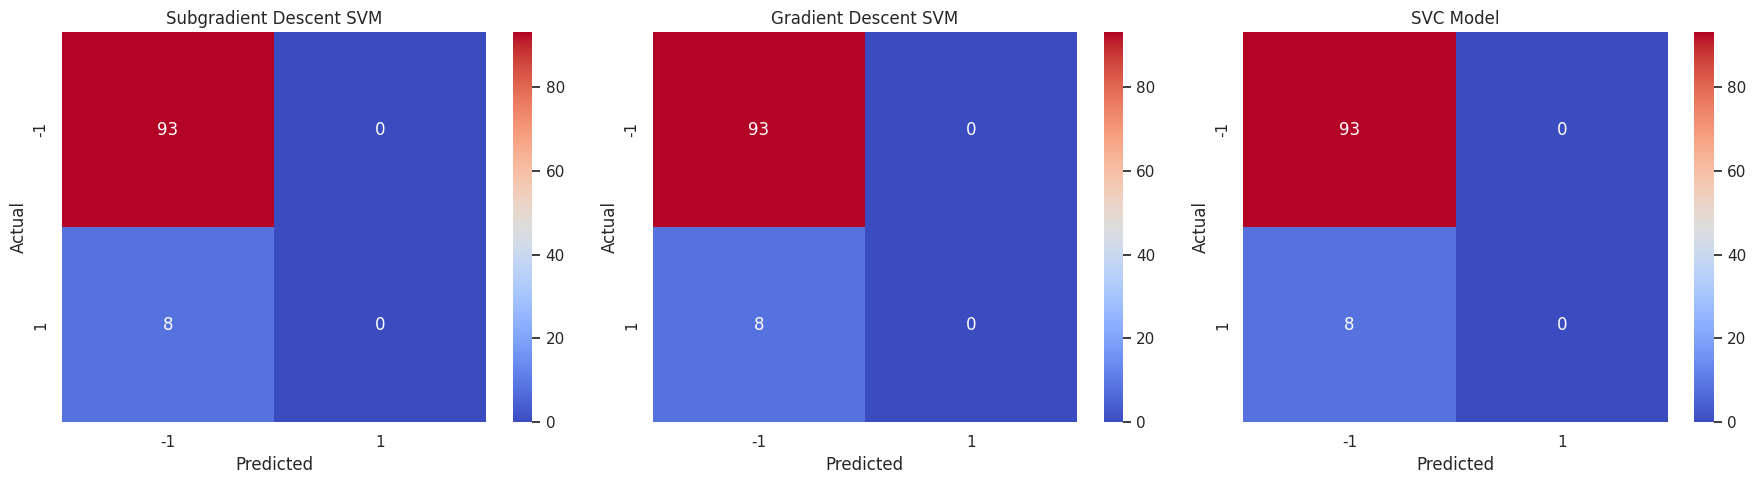

In [20]:
# === Generate predictions ===
y_pred_sub = svm_subgrad.predict(x_test)
y_pred_grad = svm_grad.predict(x_test)
y_pred_sklearn = svc_model.predict(x_test)

# === Compute confusion matrices ===
conf_matrix_sub = confusion_matrix(y_test, y_pred_sub)
conf_matrix_grad = confusion_matrix(y_test, y_pred_grad)
conf_matrix_svc = confusion_matrix(y_test, y_pred_sklearn)

# === Create subplots ===
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot Subgradient Descent SVM
sns.heatmap(conf_matrix_sub, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=['-1', '1'], yticklabels=['-1', '1'], ax=axs[0])
axs[0].set_title('Subgradient Descent SVM')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('Actual')

# Plot Gradient Descent SVM
sns.heatmap(conf_matrix_grad, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=['-1', '1'], yticklabels=['-1', '1'], ax=axs[1])
axs[1].set_title('Gradient Descent SVM')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('Actual')

# Plot Sklearn SVC
sns.heatmap(conf_matrix_svc, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=['-1', '1'], yticklabels=['-1', '1'], ax=axs[2])
axs[2].set_title('SVC Model')
axs[2].set_xlabel('Predicted')
axs[2].set_ylabel('Actual')

plt.tight_layout()
plt.show()


# **Compare Final Accuracy Across Models**

<ipython-input-18-0342ea392552>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=accuracy_percentages, palette="viridis")


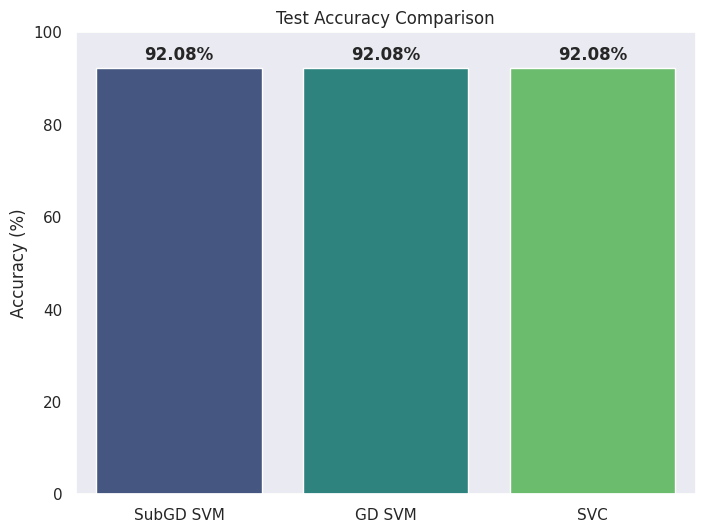

In [18]:
test_accuracies = [
    accuracy_score(y_test, y_pred_sub),
    accuracy_score(y_test, y_pred_grad),
    accuracy_score(y_test, y_pred_sklearn)
]
labels = ['SubGD SVM', 'GD SVM', 'SVC']
accuracy_percentages = [acc * 100 for acc in test_accuracies]

plt.figure(figsize=(8,6))
sns.barplot(x=labels, y=accuracy_percentages, palette="viridis")
plt.title("Test Accuracy Comparison")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.grid(axis='y')

# Add value labels on bars
for i, acc in enumerate(accuracy_percentages):
    plt.text(i, acc + 1, f"{acc:.2f}%", ha='center', va='bottom', fontweight='bold')

plt.show()
